# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following  algorithms: **Decision Tree**, **Random Forest** and **Gradient Boosted Tree**, i.e. a total of 3 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [3]:
#importing file

df = pd.read_excel('alldata.xlsx')


## Data preparation

### Feature Selection

In [6]:
columns_to_drop = ["navn", "storkreds"]
names = df['navn']
locations = df['storkreds']
parti = df['parti']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)



### Missing Data

In [8]:
#checking for null values
print(df.isnull().values.any())

False


In [9]:
#counting how many zeros are in the AGE column
print((df['alder'] == 0).sum()) #2% of the data

16


In [10]:
# target variable
y = df['parti']
X = df.drop(columns=['parti'])


In [11]:
#replacing zeros with NaN 
X['alder'] = X['alder'].replace(0, np.nan)

#Initializing IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=42)

#Fit and transform the data
df_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#round age 
df_imputed['alder'] = df_imputed['alder'].round(0)
df_imputed['parti'] = parti

## Analysis

### Age of the candidates grouped by parties

In [14]:
from statistics import mode

#group by parti
analysis = df_imputed.groupby(['parti'])
age_stats = analysis['alder'].describe()  # Get summary statistics
age_stats = age_stats.round(2)  # Round to 2 decimals for readability
#adding mode
age_stats['mode'] = analysis['alder'].agg(lambda x: mode(x))

display(age_stats)

,count,mean,std,min,25%,50%,75%,max,mode
parti,,,,,,,,,
Alternativet,67.0,47.49,13.43,21.0,40.50,48.0,57.50,79.0,50.0
Danmarksdemokraterne,37.0,51.22,10.25,24.0,45.00,53.0,59.00,69.0,48.0
Dansk Folkeparti,49.0,45.53,12.19,20.0,39.00,47.0,54.00,75.0,42.0
Det Konservative Folkeparti,98.0,44.70,11.66,20.0,37.00,47.0,53.00,66.0,53.0
Enhedslisten,74.0,42.15,14.88,19.0,31.00,40.5,52.50,74.0,35.0
"Frie Grønne, Danmarks Nye Venstrefløjsparti",26.0,34.81,10.78,20.0,27.50,33.0,37.50,62.0,33.0
Kristendemokraterne,42.0,50.43,13.35,21.0,43.00,50.5,60.75,73.0,58.0
Liberal Alliance,70.0,38.09,13.66,18.0,26.25,37.0,46.00,72.0,32.0
Løsgænger,3.0,48.00,9.17,40.0,43.00,46.0,52.00,58.0,58.0


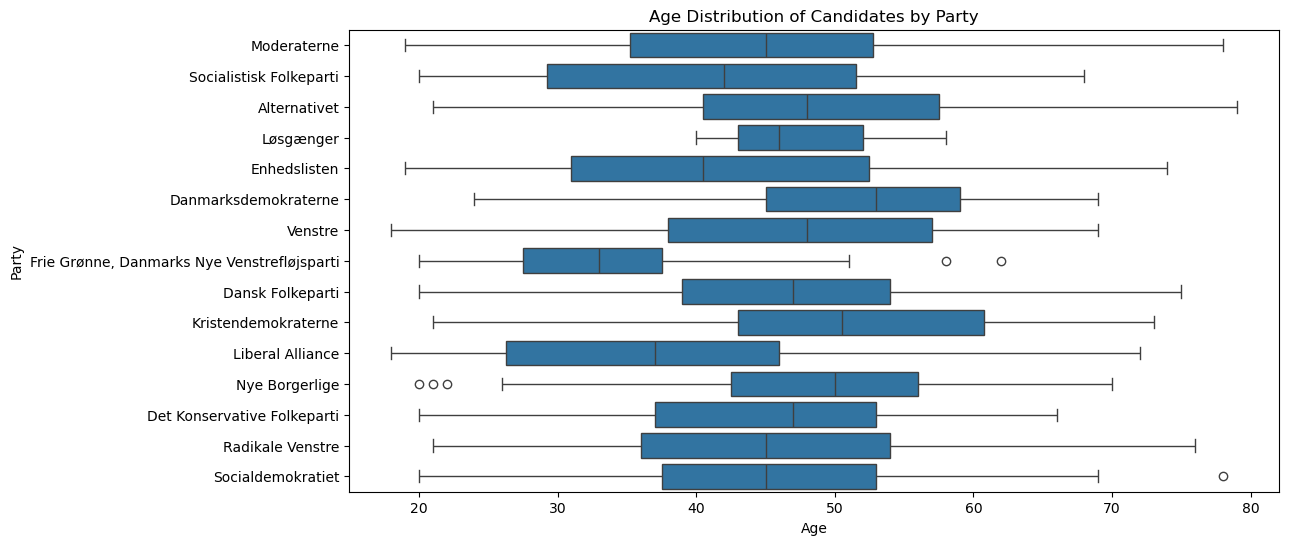

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_imputed, x='alder', y='parti', orient='h')
plt.title("Age Distribution of Candidates by Party")
plt.suptitle("")
plt.xlabel("Age")
plt.ylabel("Party")
plt.show()

### Most "confident" candidates

In [17]:
df_confidence = df
df_confidence['strong_opinions'] = df_confidence.eq(-2).sum(axis=1) + df.eq(2).sum(axis=1)
df_confidence['navn'] = names
confident_candidates = df_confidence[['navn', 'alder', 'parti', 'strong_opinions']].sort_values(by='strong_opinions', ascending=False)

print("Most confident candidates:")
confident_candidates

Most confident candidates:


,navn,alder,parti,strong_opinions
505,Sarah Nørris,43,Enhedslisten,49
88,Søren Vanting,50,Det Konservative Folkeparti,49
559,Kim Andkjær Doberck,43,Nye Borgerlige,44
152,Rashid Ali,38,"Frie Grønne, Danmarks Nye Venstrefløjsparti",43
44,Mohamed Abdikarim,33,"Frie Grønne, Danmarks Nye Venstrefløjsparti",43
...,...,...,...,...
226,Halima El Abassi,44,Socialdemokratiet,2
509,Michael Mikkelsen,50,Danmarksdemokraterne,0
643,Søren Lund Hansen,48,Dansk Folkeparti,0
699,Kasper Roug,43,Socialdemokratiet,0


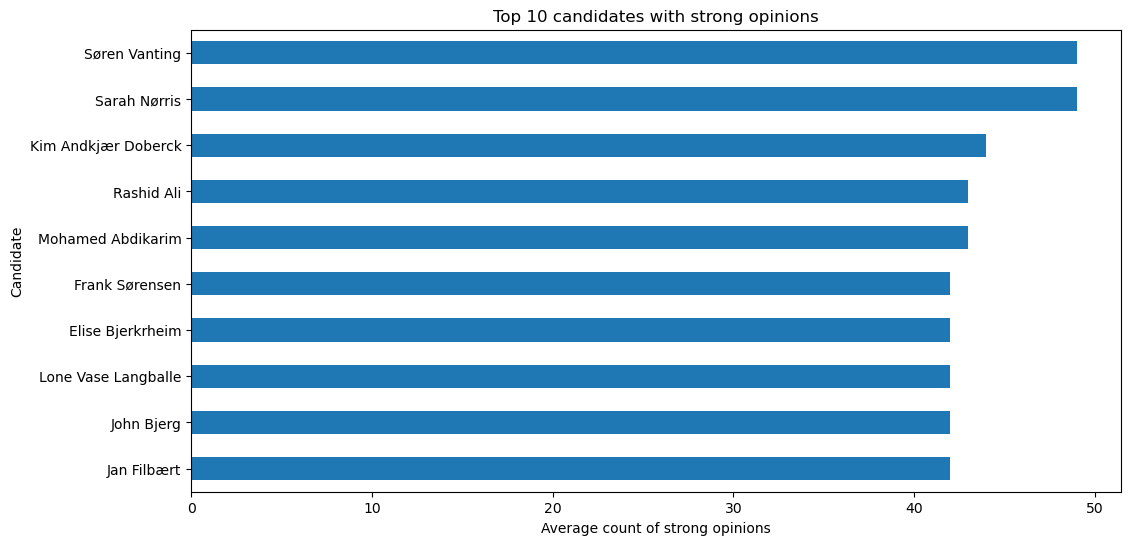

In [18]:
df_candidate_confidence = df.groupby('navn')['strong_opinions'].mean().sort_values(ascending=False)
top_10_candidates = df_candidate_confidence.head(10)

#plotting
plt.figure(figsize=(12, 6))
top_10_candidates.plot(kind='barh')
plt.title("Top 10 candidates with strong opinions")
plt.xlabel("Average count of strong opinions")
plt.ylabel("Candidate")
plt.gca().invert_yaxis()  # for top
plt.show()


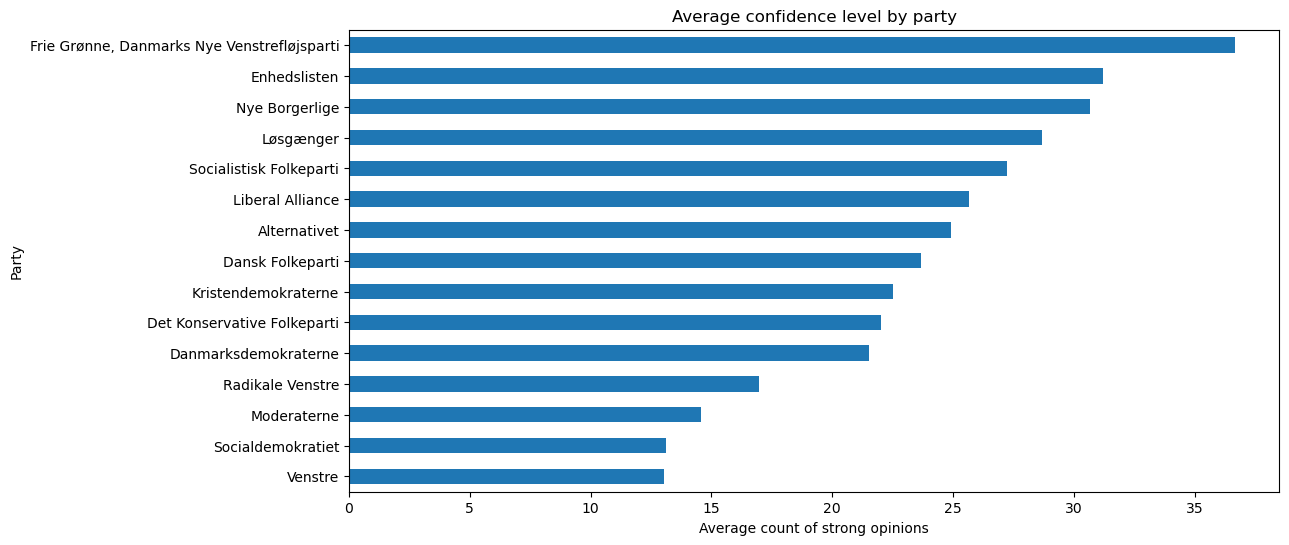

In [19]:
plt.figure(figsize=(12, 6))
df.groupby('parti')['strong_opinions'].mean().sort_values().plot(kind='barh')
plt.title("Average confidence level by party")
plt.xlabel("Average count of strong opinions")
plt.ylabel("Party")
plt.show()

### Differences in responses between candidates

In [21]:
response_columns = df.select_dtypes(include=[np.number]).columns.drop(['alder', 'strong_opinions'], errors='ignore')
party_variability = df.groupby('parti')[response_columns].std().mean(axis=1).sort_values(ascending=False)
print("Party-wise internal disagreement (higher = more disagreement):")
print(party_variability)

Party-wise internal disagreement (higher = more disagreement):
parti
Løsgænger                                      1.450230
Kristendemokraterne                            1.030463
Alternativet                                   0.909648
Moderaterne                                    0.890754
Dansk Folkeparti                               0.888009
Det Konservative Folkeparti                    0.887302
Radikale Venstre                               0.857237
Venstre                                        0.834677
Socialdemokratiet                              0.825141
Liberal Alliance                               0.730710
Enhedslisten                                   0.678929
Frie Grønne, Danmarks Nye Venstrefløjsparti    0.667277
Socialistisk Folkeparti                        0.663276
Danmarksdemokraterne                           0.608890
Nye Borgerlige                                 0.561642
dtype: float64


#### Inter-party differences: 

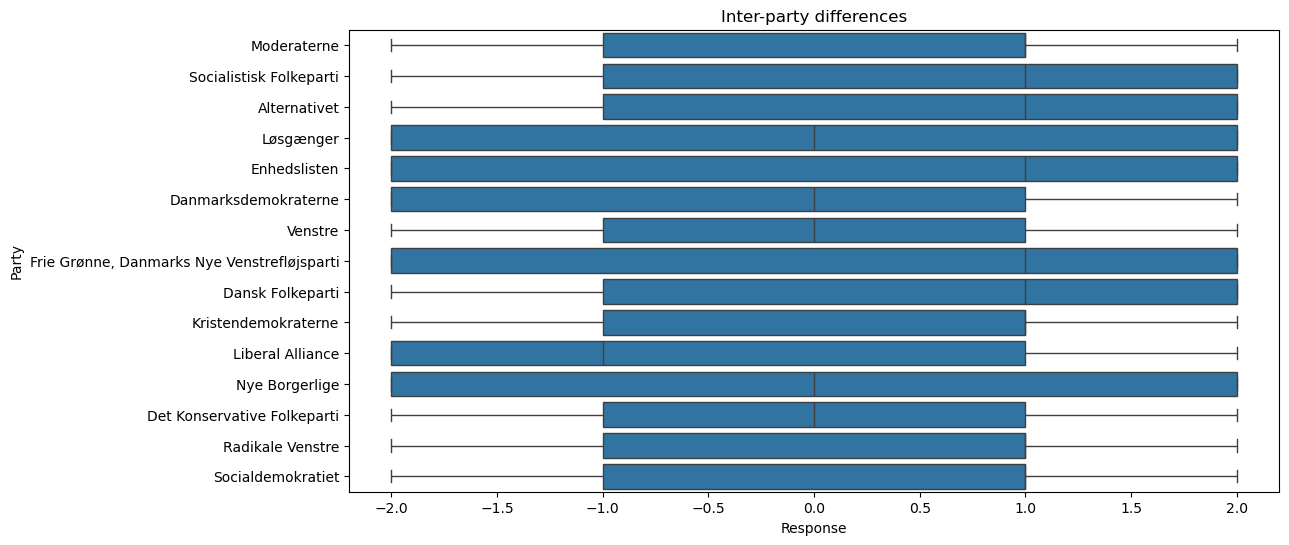

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.melt(id_vars=['parti'], value_vars=response_columns), x='value', y='parti')

plt.title("Inter-party differences")
plt.xlabel("Response")
plt.ylabel("Party")
plt.show()


Inter-party: The median response shows where parties stand on most statements.

Intra-party: The range (spread) tells us how unified or divided a party is.


Median responses per arty:
                                                    0
parti                                                
Liberal Alliance                            -0.163265
Nye Borgerlige                              -0.142857
Danmarksdemokraterne                        -0.102041
Løsgænger                                   -0.102041
Det Konservative Folkeparti                 -0.061224
Venstre                                      0.030612
Radikale Venstre                             0.122449
Frie Grønne, Danmarks Nye Venstrefløjsparti  0.132653
Dansk Folkeparti                             0.163265
Enhedslisten                                 0.163265
Socialistisk Folkeparti                      0.214286
Alternativet                                 0.224490
Kristendemokraterne                          0.224490
Socialdemokratiet                            0.326531
Moderaterne                                  0.418367


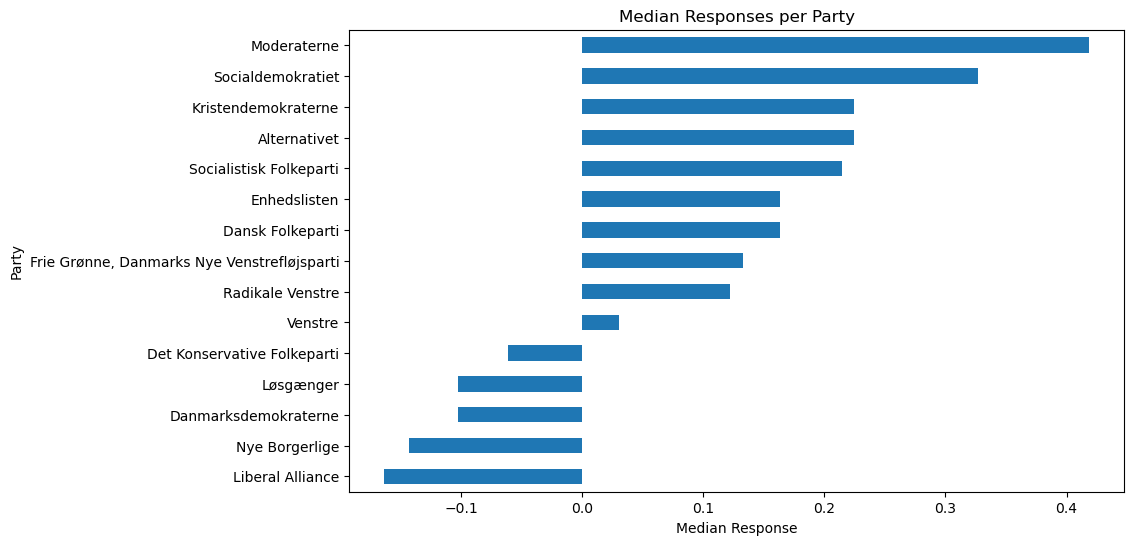

In [25]:
#exact median response per party
party_medians_exact = df.groupby('parti')[response_columns].median().mean(axis=1).sort_values()

print("Median responses per arty:")
print(party_medians_exact.to_frame())


plt.figure(figsize=(10, 6))
party_medians_exact.plot(kind='barh')
plt.title("Median Responses per Party")
plt.xlabel("Median Response")
plt.ylabel("Party")
plt.show()

Higher median (positive): generally agrees with most statements.

Lower median (negative): generally disagrees with most statements.

Moderaterne (0.4) and Socialdemokratiet (0.3) have the highest median responses, they are the most supportive of the statements.

Liberal Alliance (-0.1) has the lowest median, this party disagrees the most.

Many parties cluster around 0 (neutral stance), like Løsgængere, Det Konservative Folkeparti, and Danmarksdemokraterne.)

#### Intra-party differences: 

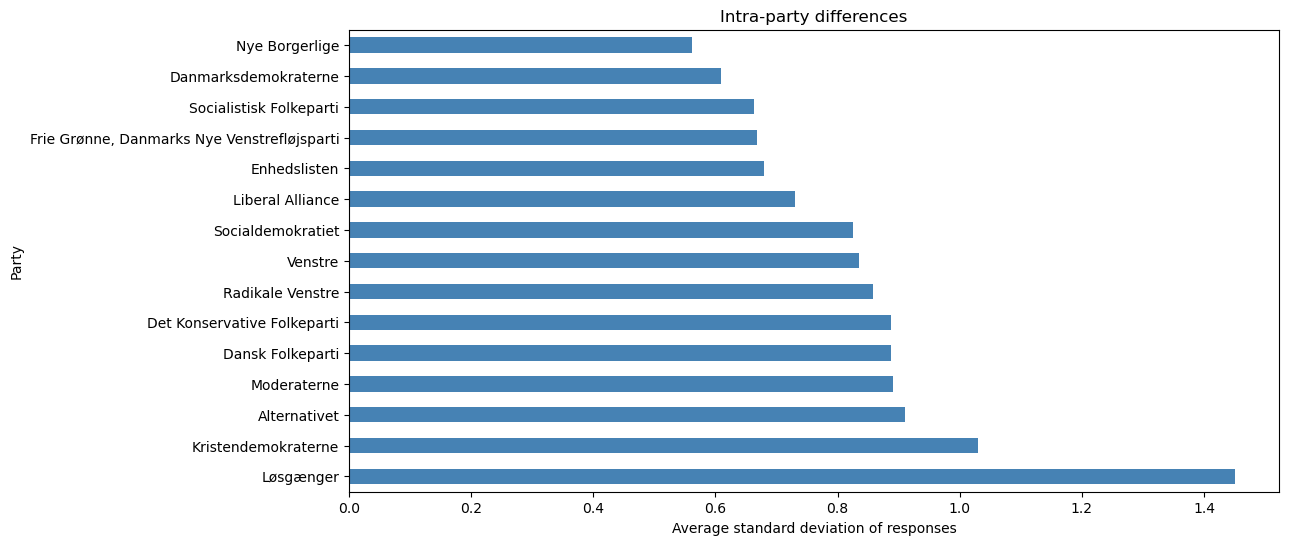

In [28]:
plt.figure(figsize=(12, 6))
party_variability.plot(kind='barh', color="steelblue")
plt.title("Intra-party differences")
plt.xlabel("Average standard deviation of responses")
plt.ylabel("Party")
plt.show()


Higher values: party has high internal disagreement (members have widely different opinions).

Lower values: party has strong unity (members largely agree on most questions).


Løsgængere (1.45) has the highest internal disagreement, so candidates strongly disagree among themselves.

Kristendemokraterne (1.03) and Alternativet (0.99) also have high internal disagreement.

Nye Borgerlige (0.56) has the lowest internal disagreement, its members are very united in their opinions.

### How different responses relate to each other

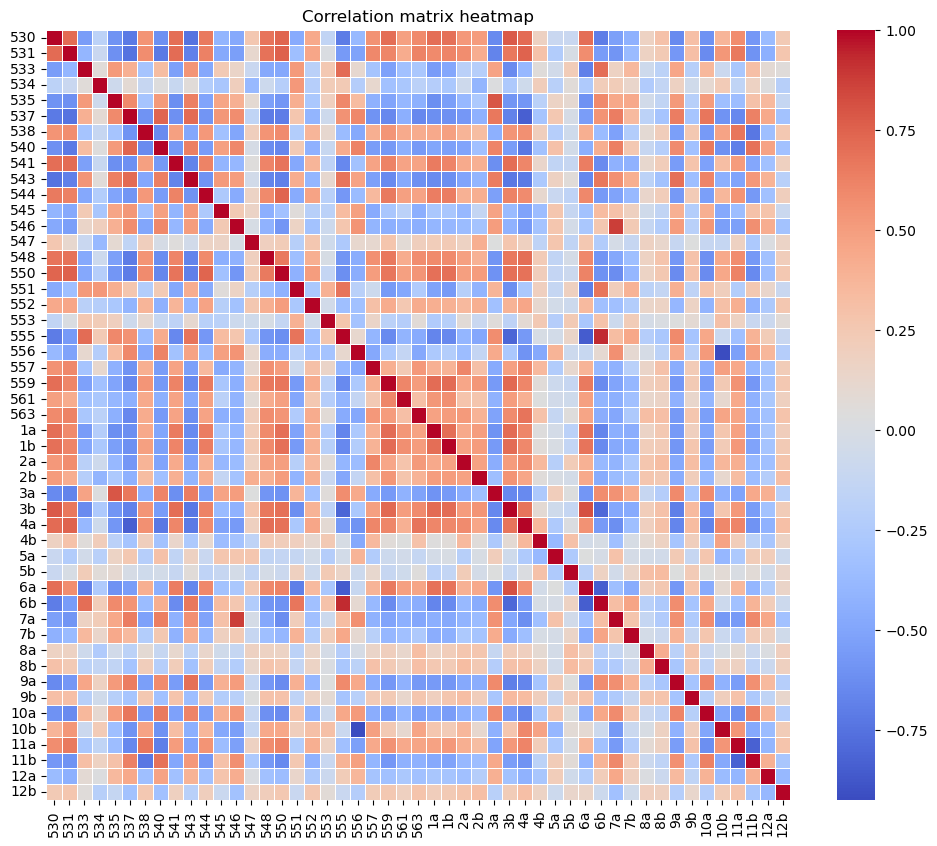

In [31]:
#calculating
corr_matrix = df[response_columns].corr()

#plotting
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Correlation matrix heatmap")
plt.show()

In [32]:
#loading files with the questions
df1 = pd.read_excel("drq.xlsx") 
df2 = pd.read_excel("tv2q.xlsx") 

#converting ids to strings for mapping
df1["ID"] = df1["ID"].astype(str)
df2["id"] = df2["id"].astype(str)

#filfter correlations that are high and low 
high_low_corr = corr_matrix[(corr_matrix > 0.75) | (corr_matrix < -0.75)]
high_low_corr = high_low_corr.dropna(how='all').dropna(axis=1, how='all')

#for better visualization
corr_pairs = high_low_corr.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_pairs = corr_pairs.dropna().query("`Feature 1` != `Feature 2`")


#mapping dictionary for questions
feature_mapping = pd.concat([
    df1.set_index("ID")["Question"], 
    df2.set_index("id")["question"]  
])

# feature codes
corr_pairs["Feature 1 Code"] = corr_pairs["Feature 1"]
corr_pairs["Feature 2 Code"] = corr_pairs["Feature 2"]

#replacing codes with questions
corr_pairs["Feature 1"] = corr_pairs["Feature 1"].map(feature_mapping)
corr_pairs["Feature 2"] = corr_pairs["Feature 2"].map(feature_mapping)

corr_pairs.head(5)

,Feature 1,Feature 2,Correlation,Feature 1 Code,Feature 2 Code
30,Danmark skal bruge flere penge på at styrke to...,Ulandsbistanden bør hæves.,0.774910,530,3b
64,Der skal indføres en særlig skat på de allerhø...,"Der skal indføres kvoter, der sikrer mindst 30...",0.752466,531,550
225,"Det er fornuftigt, at Danmark i de kommende år...",Danmark bør bruge to procent af BNP på forsvar...,0.796974,535,3a
276,"Det er okay, at den økonomiske ulighed stiger,...",Den økonomiske ulighed i det danske samfund bø...,-0.837387,537,4a
625,Danmark skal undersøge muligheden for at udvik...,Indførelse af atomkraft i Danmark vil være et ...,0.878702,546,7a


# Model

### Classification models to predict candidates' party affiliations. 


In [35]:
X = df_imputed.drop(columns=['parti'])

y = df_imputed['parti']  # target variable 

# splitting the dataset into training 80% and test 20%
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitting training data into training 80% and validation 20%
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=43)

print("Size of training set:", X_train.shape[0])
print("Size of validation set:", X_val.shape[0])
print("Size of test set:", X_test.shape[0])


Size of training set: 554
Size of validation set: 139
Size of test set: 174


#### Decision Tree Classifier

In [37]:
clf = DecisionTreeClassifier(max_depth=4, random_state=42) #change max_depth to see how it affected
clf.fit(X_train, y_train)

print("Decision Tree Accuracy:")
print("Training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Validation set: {:.3f}".format(clf.score(X_val, y_val)))
#print("Test set: {:.3f}".format(clf.score(X_test, y_test)))

Decision Tree Accuracy:
Training set: 0.700
Validation set: 0.604


#### Random Forest Classifier

In [39]:
forest = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=10, random_state=0)
forest.fit(X_train, y_train)

print("\nRandom Forest Accuracy:")
print("Training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Validation set: {:.3f}".format(forest.score(X_val, y_val)))
#print("Test set: {:.3f}".format(forest.score(X_test, y_test)))



Random Forest Accuracy:
Training set: 0.888
Validation set: 0.835


#### Gradient Boosting Classifier

In [41]:
gbt = GradientBoostingClassifier(
    n_estimators=1500, max_depth=3, learning_rate=0.05, subsample=0.70,
    validation_fraction=0.2, n_iter_no_change=20, random_state=5
)


gbt.fit(X_train, y_train)

print("\nGradient Boosting Accuracy:")
print("Training set: {:.3f}".format(gbt.score(X_train, y_train)))
print("Validation set: {:.3f}".format(gbt.score(X_val, y_val)))
#print("Test set: {:.3f}".format(gbt.score(X_test, y_test)))


Gradient Boosting Accuracy:
Training set: 0.977
Validation set: 0.842


In [42]:
models = {
    "Decision Tree": clf,
    "Random Forest": forest,
    "Gradient Boosted Tree": gbt
}

results = {} 

for name, model in models.items():
    #training the model
    model.fit(X_train, y_train)
    
    #predicting on test data
    y_pred = model.predict(X_val)
    
    #calculating accuracy
    accuracy = accuracy_score(y_val, y_pred)
    results[name] = accuracy
    
    #report
    print(f"\n{name} Model performance:")
    print(classification_report(y_val, y_pred, zero_division=1))



Decision Tree Model performance:
                                             precision    recall  f1-score   support

                               Alternativet       0.78      0.58      0.67        12
                       Danmarksdemokraterne       1.00      0.00      0.00         5
                           Dansk Folkeparti       0.69      0.82      0.75        11
                Det Konservative Folkeparti       0.44      0.92      0.60        13
                               Enhedslisten       0.90      0.82      0.86        11
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.50      0.60      0.55         5
                        Kristendemokraterne       1.00      0.00      0.00         5
                           Liberal Alliance       1.00      0.00      0.00        11
                                  Løsgænger       1.00      0.00      0.00         1
                                Moderaterne       0.50      0.57      0.53         7
                             N

In [43]:
import graphviz
import pydotplus


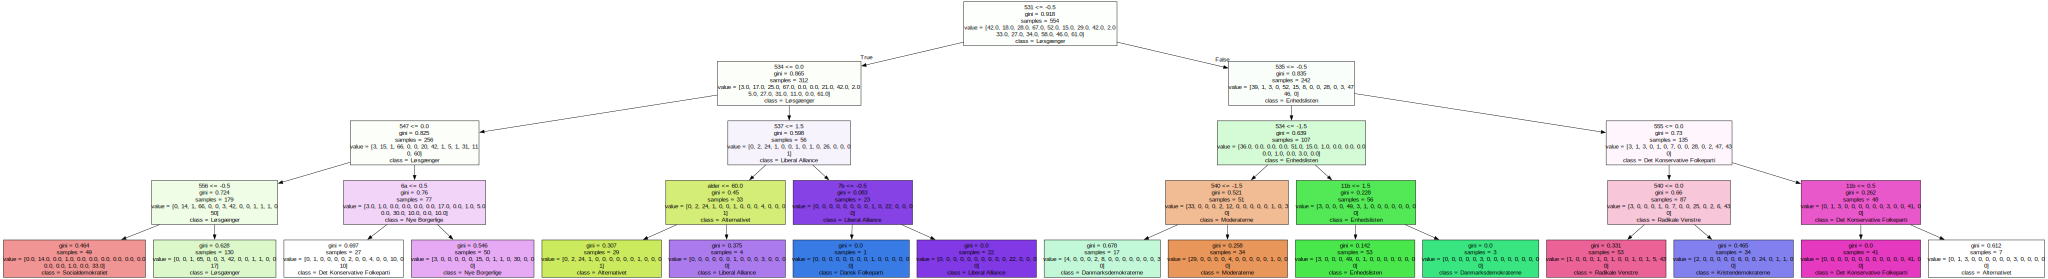

In [44]:
# Visualizing the Decision Tree
dt_model = models["Decision Tree"]
dot_data = export_graphviz(dt_model, out_file=None, class_names=y.unique(), feature_names=X.columns, filled=True)
graph = graphviz.Source(dot_data)
graph

###  Candidates who seem to be in the "wrong" party based on their political landscape positions

In [46]:
X_test_indices = X_test.index  

navn_test = names.loc[X_test_indices]  # extracting only names of the dataset test

#using  best-performing model Gradient Boosted Tree to predict test data
y_test_pred = gbt.predict(X_test)

#dataFrame to compare actual vs predicted party 
misclassified_df = pd.DataFrame({
    "Candidate Name": navn_test,  
    "Actual Party": y_test,
    "Predicted Party": y_test_pred
})

#filtering
misclassified_candidates = misclassified_df[misclassified_df["Actual Party"] != misclassified_df["Predicted Party"]]

misclassified_candidates.head(5)


,Candidate Name,Actual Party,Predicted Party
604,Jakob Schmidt,Alternativet,Radikale Venstre
76,Sofie Lippert,Socialistisk Folkeparti,Alternativet
481,Michael Flarup,Radikale Venstre,Socialistisk Folkeparti
525,Marianne Karlberg,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet
433,Rishi Balachandran,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Enhedslisten


### Feature Importance


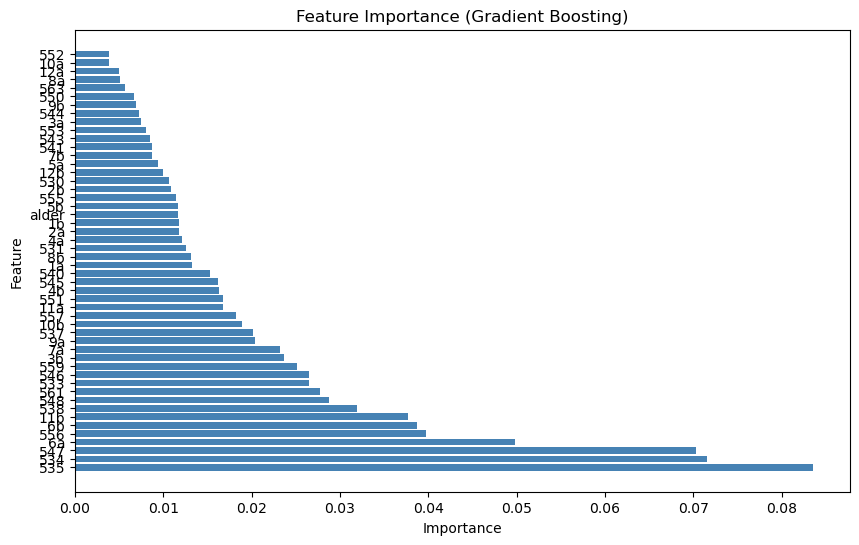

In [48]:
importances = gbt.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='steelblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Gradient Boosting)")
plt.show()

In [49]:
#loading files with the questions
df1 = pd.read_excel("drq.xlsx") 
df2 = pd.read_excel("tv2q.xlsx") 

#feature importance from model
importances = gbt.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#converting ids to strings for mapping
df1["ID"] = df1["ID"].astype(str)
df2["id"] = df2["id"].astype(str)
feature_importance_df["Feature"] = feature_importance_df["Feature"].astype(str)

#mapping dictionary for questions
feature_mapping = pd.concat([
    df1.set_index("ID")["Question"],  
    df2.set_index("id")["question"]    
])

#replacing codes with  questions
feature_importance_df["Feature"] = feature_importance_df["Feature"].map(feature_mapping)

#sorting by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)

pd.set_option('display.max_colwidth', None)
feature_importance_df


,Feature,Importance
4,"Det er fornuftigt, at Danmark i de kommende år bruger markant flere penge på forsvaret",0.083529
3,På sigt skal Danmark meldes ud af EU,0.071583
13,Der bør dannes en regering hen over midten,0.070243
35,Den danske udlændingepolitik er for stram.,0.049790
20,Den såkaldte Arne-pension skal afskaffes,0.039693
36,Det vil være en god idé at etablere et dansk asylmodtagecenter i Rwanda.,0.038718
46,"Det bør undersøges, om Mette Frederiksen kan stilles for en rigsret som konsekvens af hendes håndtering af Mink-sagen.",0.037682
6,Forældres indkomst skal være et af kriterierne for fordeling af elever i gymnasiet,0.031926
14,"Der skal afsættes penge til at hjælpe kontanthjælpsmodtagere, når priserne stiger",0.028802
23,"Det er en god idé med naturnationalparker, hvor der bliver udsat store dyr, som lever vildt",0.027721


For future reference, a good thing to do additionally for this assignment would've been to use lasso or ridge regression on the features, so that only a set of features would have an impact on the final models.